In [1]:
# First approach to Smart Charging Phase 1 using PuLP.
# Modeled as a PuLP optimisation blending problem
# Started 20 Aug 2020
# Author: Sofia Taylor, Flexible Power Systems

import numpy as np
import pandas as pd
import datetime as dt
from pulp import *
import pickle
import global_variables as gv
import functions as f
import output_functions as of
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import random
import matplotlib.dates as mdates
import matplotlib.font_manager as font_manager
import lin_prog_functions as lpf


In [2]:
#grid_file_path = 'Outputs/Logs/grid_variables{}.csv'.format(run)
journeys_range = pickle.load(open('Outputs/journeys_range','rb'))
price_data = pickle.load(open('Outputs/price_data','rb'))
empty_profile = pickle.load(open('Outputs/empty_profile','rb'))
#empty_profile = f.create_empty_schedule(journeys_range, price_data)
chargers = [11,22]
charger = 20
capacity = 30
ca='opt'
site_capacity = {
    'opt': capacity,  
    'BAU': 10000,
    'BAU2': capacity
}

Run: 100 / Charger: 20 / Capacity: 30
opt status: Infeasible
opt Next required charge status: Optimal
Cost: -23706.099998184014
BAU status: Optimal
Cost: 13.583313372140005
BAU2 status: Infeasible
BAU2 Next required charge status: Optimal
Cost: -26187.109998001055
2019-01-31 Status: -1 : -1 1 -1
opt status: Infeasible
opt Next required charge status: Optimal
Cost: -25593.00000180801
BAU status: Optimal
Cost: 25.470276400900005
BAU2 status: Infeasible
BAU2 Next required charge status: Optimal
Cost: -28472.265003996315
2019-02-01 Status: -1 : -1 1 -1
opt status: Optimal
Cost: 2522.5855328799994
BAU status: Optimal
Cost: 32.9111924773
BAU2 status: Optimal
Cost: 35.451344160276
2019-02-02 Status: 3 : 1 1 1
opt status: Optimal
Cost: 2187.20583024
BAU status: Optimal
Cost: 48.07804987091001
BAU2 status: Optimal
Cost: 48.61263848109999
2019-02-03 Status: 3 : 1 1 1
opt status: Optimal
Cost: 2531.2878711589997
BAU status: Optimal
Cost: 60.8387470807
BAU2 status: Optimal
Cost: 61.15663885755199


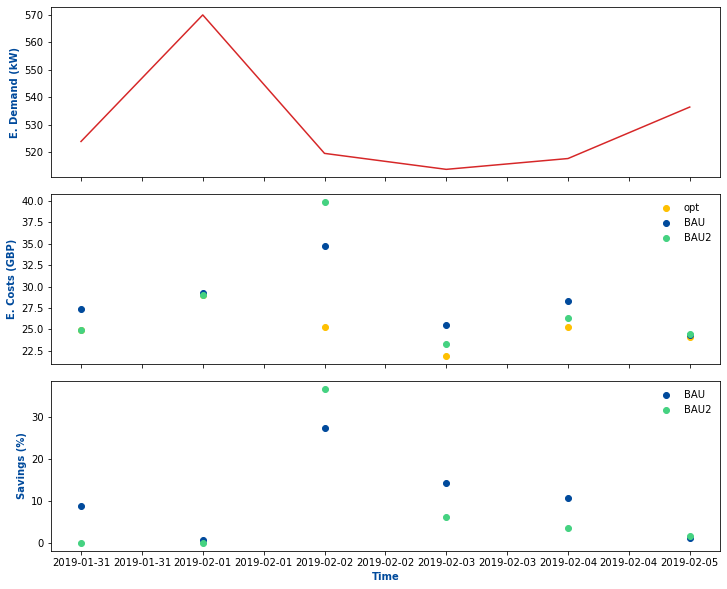

In [8]:
## Range Test

run = 100
notes = 'Fixing scatter plot'

script_strt = time.process_time()
print('Run:',run,'/ Charger:',charger,'/ Capacity:',capacity)
os.makedirs('Outputs/Logs/run{}'.format(run))

profile_out, dates, bad_days, lpprob = lpf.optimise_range2(
    empty_profile, 
    chargers, 
    site_capacity)

range_profile, site_profile, days_summary, global_summary = of.summary_outputs(
    profile_out, 
    journeys_range, 
    dates)

os.makedirs('Outputs/Logs/run{}/daily'.format(run))
for date in dates:
    day = dt.datetime.combine(date, dt.datetime.min.time())
    day_profile = of.create_daily_summary(site_profile, day)
    fig_summary = of.summary_plot(day_profile)
    fig_summary.savefig(
        'Outputs/Logs/run{}/daily/fig{}.jpg'.format(run,date))
    plt.close(fig_summary)

with open('Outputs/Logs/run{}/variables{}.csv'.format(run,run),'a') as fi:
    fi.write(notes)
    fi.write('\n' + str(run)+'\n'+str(charger) + '\n' + str(capacity) +'\n')
    fi.write(global_summary.to_string())
    fi.write(bad_days)

range_fig = of.daily_summary_plot(days_summary.fillna(0))
range_fig.savefig(
            'Outputs/Logs/run{}/fig_range{}.svg'.format(run,run),
            bbox_inches = "tight")
range_fig.show()

In [12]:
type(gv.DAY)

datetime.datetime

In [5]:
## Single Day test
req_energy = empty_profile.groupby(
    ['date','Vehicle_ID']).sum()[['Battery_Use']]*(
        1+gv.MARGIN_SOC)
last_day = req_energy.index[-1][0]+dt.timedelta(days=1)
for v in empty_profile.index.get_level_values('Vehicle_ID').unique():
    req_energy.loc[(last_day,v),'Battery_Use'] = 0
req_energy['Full_Use'] = -gv.BATTERY_CAPACITY
req_energy['Req_Battery'] = req_energy[['Battery_Use','Full_Use']].max(axis=1)
day = gv.DAY
day_profile = f.create_daily_schedule(empty_profile, day)
next_req = req_energy.loc[(day+dt.timedelta(days=1),slice(None)),'Req_Battery'].droplevel(level=0)
initial_rel_charge = pd.Series(
        data = [0,0,0,0,0],
        index = empty_profile.index.get_level_values(1).unique()
    )

output_df, PuLP_prob, fsoc, _ = lpf.linear_optimiser_V4(
                    day_profile,
                    ca,
                    chargers[0],chargers[1],
                    site_capacity,
                    initial_rel_charge,
                    next_req
                    )

day_profile_out = day_profile.merge(
                output_df,
                how='left',
                left_index=True,
                right_index=True,
                )
range_profile = day_profile_out.fillna(0)
cols=gv.CAT_COLS
vehicles = output_df.index.get_level_values(1).unique()

range_profile[cols['CHARGE_DEL'][ca]] = (
    range_profile[cols['OUTPUT'][ca]] 
    * gv.CHARGER_EFF)
range_profile[cols['ECOST'][ca]] = (
    range_profile[cols['OUTPUT'][ca]] 
    * range_profile[cols['PRICE']['opt']])
for vehicle in vehicles:
    range_profile.loc[(slice(None),vehicle),cols['SOC'][ca]] = (
        gv.BATTERY_CAPACITY + initial_rel_charge
        + range_profile.loc[(slice(None),vehicle),cols['CHARGE_DEL'][ca]].cumsum() 
        + range_profile.loc[(slice(None),vehicle),'Battery_Use'].cumsum()
        )*100/gv.BATTERY_CAPACITY

opt status: Infeasible
opt Next required charge status: Optimal
Cost: -23706.099998184014


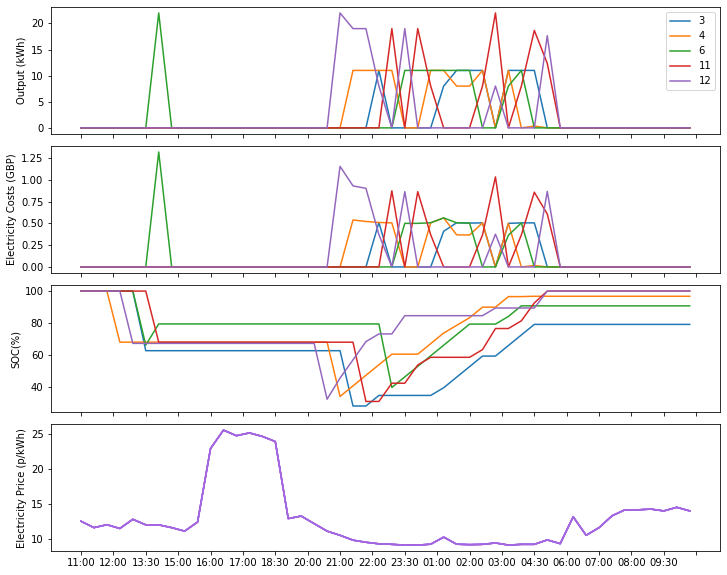

In [6]:
fig, axs = plt.subplots(
    4,
    figsize=(12,10),
    sharex=True, 
    gridspec_kw={'hspace':0.1})

x = range_profile.unstack().index.strftime('%H:%M')
cols = gv.CAT_COLS

axs[0].plot(
    x, 
    range_profile.unstack()[cols['OUTPUT'][ca]]*2)
axs[0].legend(range_profile.unstack()[cols['OUTPUT'][ca]].columns)
axs[0].set_ylabel('Output (kWh)')

axs[1].plot(
    x, 
    range_profile.unstack()[cols['ECOST'][ca]]/100)
axs[1].set_ylabel('Electricity Costs (GBP)')

axs[2].plot(
    x, 
    range_profile.unstack()[cols['SOC'][ca]])
axs[2].set_ylabel('SOC(%)')

axs[3].plot(
    x, 
    range_profile.unstack()[cols['PRICE']['opt']], 
    color=gv.FPS_PURPLE)
axs[3].set_ylabel('Electricity Price (p/kWh)')
for ax in fig.get_axes():
    ax.xaxis.set_major_locator(plt.MaxNLocator(24))
fig.show()

In [16]:
range_profile.sum()

Electricity_Price     3097.000000
Time_Price              10.920000
Available               72.000000
Battery_Use           -260.802633
Session               1782.000000
Return                  10.000000
Output_Opt             289.780704
Ch                      33.000000
ChDelivered_Opt        260.802634
ECost_Opt             2725.214949
SoC_Opt              18829.016974
dtype: float64